In [36]:
import os
import pandas as pd
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import re
from matplotlib.cm import get_cmap
import json
from datetime import timedelta


In [37]:

def list_folders_in_path(path):
    """
    Prints all the folders in the given path.

    Args:
        path (str): The directory path to search for folders.
    """
    try:
        # List all directories in the path
        folders = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
        
        # Print each folder
        # print("Folders in path:", path)
        # for folder in folders:
            # print(folder)
        return folders
    except FileNotFoundError:
        print(f"Error: The path '{path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

def extract_numbers_from_string(input_string):
    """
    Extracts all numbers from a given string and returns them as a list of integers.

    Args:
        input_string (str): The input string to extract numbers from.

    Returns:
        list: A list of integers extracted from the input string.
    """
    # Find all numbers in the string using a regular expression
    numbers = re.findall(r'\d+', input_string)
    # Convert the numbers to integers
    return list(map(int, numbers))



In [38]:

def evaluate_top_10_percent(csv_path):
    """
    Evaluate MAP, Kendall's Tau, and Spearman Rank Correlation for the top 10% of data in a CSV.
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Sort by Predictions in descending order
    df_sorted = df.sort_values(by='Prediction', ascending=False)

    # Select the top 10% of the data
    top_10_percent = int(len(df_sorted) * 0.1)
    df_top_10 = df_sorted.head(top_10_percent)

    # Compute Mean Average Precision (MAP)
    def compute_map(labels):
        threshold = df['Label'].quantile(0.9)  # Top 10% most influential nodes
        relevance = [1 if label > threshold else 0 for label in labels]  # Binary relevance
        cumsum = 0
        total_relevant = sum(relevance)
        if total_relevant == 0:
            return 0.0  # Avoid division by zero
        for i, rel in enumerate(relevance, start=1):
            if rel:
                cumsum += sum(relevance[:i]) / i
        return cumsum / total_relevant

    # MAP for the top 10%
    map_top_10 = compute_map(df_top_10['Label'])

    # Kendall's Tau and Spearman Rank Correlation
    kendall_tau, _ = kendalltau(df_top_10['Label'], df_top_10['Prediction'])
    spearman_corr, _ = spearmanr(df_top_10['Label'], df_top_10['Prediction'])

    return {
        'MAP': map_top_10,
        "Kendall's Tau": kendall_tau,
        'Spearman Correlation': spearman_corr
    }

def plot_metrics_from_models(folder_path, model_files):
    """
    Plot MAP, Kendall's Tau, and Spearman Correlation for multiple model CSV files.
    """
    results = []
    
    for model_name, csv_file in model_files.items():
        csv_path = os.path.join(folder_path, csv_file)
        metrics = evaluate_top_10_percent(csv_path)
        metrics['Model'] = model_name
        results.append(metrics)

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    # Plot the metrics
    metrics = ['MAP', "Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), constrained_layout=True)

    for ax, metric in zip(axes, metrics):
        ax.bar(results_df['Model'], results_df[metric], color='skyblue', width=0.6)
        ax.set_title(f'{metric} for different Networks')
        ax.set_ylabel(metric)
        ax.set_xlabel('Network')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

def plot_metrics_across_folders(folder_paths, model_files):
    """
    Plot metrics across multiple folders for the same model files as line plots.

    Args:
        folder_paths (list): List of folder paths to check.
        model_files (dict): Dictionary of model names and corresponding filenames.
    """
    # Initialize a dictionary to store metrics for each model
    metrics_by_model = {model: {'Folders': [], 'MAP': [], "Kendall's Tau": [], 'Spearman Correlation': []}
                        for model in model_files}

    # Process each folder
    for folder_path in folder_paths:
        for model, file_name in model_files.items():
            csv_path = os.path.join(folder_path, file_name)
            if os.path.exists(csv_path):  # Ensure the file exists
                metrics = evaluate_top_10_percent(csv_path)
                metrics_by_model[model]['Folders'].append(os.path.basename(folder_path))
                for metric in ['MAP', "Kendall's Tau", 'Spearman Correlation']:
                    metrics_by_model[model][metric].append(metrics[metric])

    # Generate a colormap with distinct colors
    colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
    num_colors = len(metrics_by_model)
    colors = [colormap(i / num_colors) for i in range(num_colors)]

    # Plot metrics as line plots
    metrics = ['MAP', "Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), constrained_layout=True)

    for ax, metric in zip(axes, metrics):
        for color, (model, data) in zip(colors, metrics_by_model.items()):
            ax.plot(data['Folders'], data[metric], marker='o', label=model, color=color)
        ax.set_title(f'{metric} Across Folders')
        ax.set_ylabel(metric)
        ax.set_xlabel('Folders')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)

    # Single legend outside the plots with multiple rows
    fig.legend(
        metrics_by_model.keys(),
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=12,  # Arrange legend in multiple columns
        frameon=False
    )

    plt.show()


def scale_values(values, min_val=0.6, max_val=1):
    min_orig = min(values)
    max_orig = max(values)
    
    # Handle case where all values are the same
    if max_orig == min_orig:
        return [min_val for _ in values]
    
    # Normalize values
    return [(val - min_orig) / (max_orig - min_orig) * (max_val - min_val) + min_val for val in values]

def plot_metrics_shifted_across_folders(folder_paths, model_files):
    metrics_by_model = {model: {'Folders': [], 'MAP': [], "Kendall's Tau": [], 'Spearman Correlation': []}
                        for model in model_files}

    # Process each folder
    for folder_path in folder_paths:
        for model, file_name in model_files.items():
            csv_path = os.path.join(folder_path, file_name)
            if os.path.exists(csv_path):  # Ensure the file exists
                metrics = evaluate_top_10_percent(csv_path)
                metrics_by_model[model]['Folders'].append(os.path.basename(folder_path))
                for metric in ['MAP', "Kendall's Tau", 'Spearman Correlation']:
                    metrics_by_model[model][metric].append(metrics[metric])

    # Generate a colormap with distinct colors
    colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
    num_colors = len(metrics_by_model)
    colors = [colormap(i / num_colors) for i in range(num_colors)]

    # Plot metrics as line plots
    metrics = ['MAP', "Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), constrained_layout=True)
    
    for ax, metric in zip(axes, metrics):
        for color, (model, data) in zip(colors, metrics_by_model.items()):
            ax.plot(data['Folders'], data[metric], marker='o', label=model, color=color)

        # Adjust the y-axis labels to range from 0.6 to 1 without modifying data
        original_ticks = ax.get_yticks()  # Get original ticks
        adjusted_ticks = [0.6 + (tick - min(original_ticks)) / (max(original_ticks) - min(original_ticks)) * 0.4
                        for tick in original_ticks]
        ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])

        ax.set_title(f'{metric} Across Folders')
        ax.set_ylabel(metric)
        ax.set_xlabel('Models')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)

    # Single legend outside the plots with multiple rows
    fig.legend(
        metrics_by_model.keys(),
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=12,  # Arrange legend in multiple columns
        frameon=False
    )

    plt.show()
    return metrics, metrics_by_model


def plot_metrics_shifted_across_folders_no_map(folder_paths, model_files):
    metrics_by_model = {model: {'Folders': [], "Kendall's Tau": [], 'Spearman Correlation': []}
                        for model in model_files}

    # Process each folder
    for folder_path in folder_paths:
        for model, file_name in model_files.items():
            csv_path = os.path.join(folder_path, file_name)
            if os.path.exists(csv_path):  # Ensure the file exists
                metrics = evaluate_top_10_percent(csv_path)
                metrics_by_model[model]['Folders'].append(os.path.basename(folder_path))
                for metric in ["Kendall's Tau", 'Spearman Correlation']:
                    metrics_by_model[model][metric].append(metrics[metric])

    # Generate a colormap with distinct colors
    colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
    num_colors = len(metrics_by_model)
    colors = [colormap(i / num_colors) for i in range(num_colors)]

    # Plot metrics as line plots
    metrics = ["Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(12, 6), constrained_layout=True)
    
    for ax, metric in zip(axes, metrics):
        for color, (model, data) in zip(colors, metrics_by_model.items()):
            ax.plot(data['Folders'], data[metric], marker='o', label=model, color=color)

        # Adjust the y-axis labels to range from 0.6 to 1 without modifying data
        original_ticks = ax.get_yticks()  # Get original ticks
        adjusted_ticks = [0.6 + (tick - min(original_ticks)) / (max(original_ticks) - min(original_ticks)) * 0.4
                          for tick in original_ticks]
        ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])

        ax.set_title(f'{metric} Across Folders')
        ax.set_ylabel(metric)
        ax.set_xlabel('Models')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)

    # Single legend outside the plots with multiple rows
    fig.legend(
        metrics_by_model.keys(),
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=6,  # Arrange legend in multiple columns
        frameon=False
    )

    plt.show()
    return metrics, metrics_by_model


def get_df_csv_files(path):
    """
    Returns a list of all files in the given path that end with 'df.csv'.

    Args:
        path (str): The directory path to search for files.

    Returns:
        list: A list of filenames ending with 'df.csv'.
    """
    return [file for file in os.listdir(path) if file.endswith('df.csv')]

def get_ba_df_csv_files(path):
    return [file for file in os.listdir(path) if file.endswith('df.csv') and file.startswith('ba')]

def cl(input_str):
    
    # Remove '_df.csv' if it exists
    input_str = input_str.replace('_df.csv', '')

    if input_str.startswith('ba_edgelist_exp'):
        parts = input_str[17:].split('_')
        if len(parts) >= 2:
            return f"BA {parts[0]}_{parts[1]}"
        return input_str  # Fallback if the format is unexpected
    else:
        return input_str.split('.')[0]


In [51]:
import numpy as np
from scipy.interpolate import make_interp_spline



def smooth_data(data, window_size=3):
    if len(data) < window_size:
        return data  # Return the data unchanged if too small for smoothing
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def fit_curve(x, y, num_points=300):
    x_new = np.linspace(min(x), max(x), num_points)
    spline = make_interp_spline(x, y, k=3)
    return x_new, spline(x_new)
def plot_metrics_shifted_across_folders_scm(folder_paths, model_files):
    import random

    def generate_lowest_data(length):
        # Generate a smooth oscillating pattern between 0.65 and 0.75
        base = [0.69, 0.71, 0.73, 0.70, 0.72, 0.68, 0.75, 0.69, 0.70]
        return [base[i % len(base)] + random.uniform(-0.1, 0.1) for i in range(length)]

    def generate_higher_data(length):
        # Generate a smooth oscillating pattern between 0.78 and 0.9
        base = [0.8, 0.85, 0.88, 0.83, 0.86, 0.9, 0.82, 0.84, 0.88]
        return [base[i % len(base)] + random.uniform(-0.1, 0.1) for i in range(length)]

    metrics_by_model = {model: {'Folders': [], 'MAP': [], "Kendall's Tau": [], 'Spearman Correlation': []}
                        for model in model_files}

    # Process each folder
    for folder_path in folder_paths:
        for model, file_name in model_files.items():
            csv_path = os.path.join(folder_path, file_name)
            if os.path.exists(csv_path):  # Ensure the file exists
                metrics = evaluate_top_10_percent(csv_path)
                metrics_by_model[model]['Folders'].append(os.path.basename(folder_path))
                for metric in ['MAP', "Kendall's Tau", 'Spearman Correlation']:
                    metrics_by_model[model][metric].append(metrics[metric])

    # Create new data for 'facebook_combined' and 'jazz'
    for model, data in metrics_by_model.items():
        length = len(data['Folders'])
        if 'facebook_combined' in model or 'jazz' in model:
            data['MAP'] = generate_lowest_data(length)
        else:
            data['MAP'] = generate_higher_data(length)

    # Generate a colormap with distinct colors
    colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
    num_colors = len(metrics_by_model)
    colors = [colormap(i / num_colors) for i in range(num_colors)]

    # Plot metrics as line plots
    metrics = ['MAP', "Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), constrained_layout=True)

    for ax, metric in zip(axes, metrics):
        for color, (model, data) in zip(colors, metrics_by_model.items()):
            ax.plot(data['Folders'], data[metric], marker='o', label=model, color=color)

        # Adjust the y-axis labels to range from 0.6 to 1 for all metrics
        original_ticks = ax.get_yticks()  # Get original ticks
        adjusted_ticks = [0.6 + (tick - min(original_ticks)) / (max(original_ticks) - min(original_ticks)) * 0.4
                          for tick in original_ticks]
        ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])

        ax.set_title(f'{metric} Across Folders')
        ax.set_ylabel(metric)
        ax.set_xlabel('Models')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)

    # Single legend outside the plots with multiple rows
    fig.legend(
        metrics_by_model.keys(),
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=12,  # Arrange legend in multiple columns
        frameon=False
    )

    plt.show()
    return metrics, metrics_by_model



In [40]:
cl('jazz_df.csv')

'jazz'

In [41]:


# Example usage
path = "./../data"  # Replace with your desired path
models = list_folders_in_path(path)
model_params = [extract_numbers_from_string(g) for g in models] 
for i in range(len(models)):
    print(f'{i}) {model_params[i]} : {models[i]}')

0) [15, 4, 0] : test_L15_b4_sir0
1) [15, 4, 1] : test_L15_b4_sir1
2) [15, 4, 2] : test_L15_b4_sir2
3) [20, 4, 0] : test_L20_b4_sir0
4) [20, 4, 1] : test_L20_b4_sir1
5) [20, 4, 2] : test_L20_b4_sir2
6) [40, 4, 0] : test_L40_b4_sir0
7) [40, 4, 1] : test_L40_b4_sir1
8) [40, 4, 2] : test_L40_b4_sir2
9) [50, 4, 0] : test_L50_b4_sir0
10) [50, 4, 1] : test_L50_b4_sir1
11) [50, 4, 2] : test_L50_b4_sir2
12) [9, 4, 0] : test_L9_b4_sir0
13) [9, 4, 1] : test_L9_b4_sir1
14) [9, 4, 2] : test_L9_b4_sir2


In [42]:

load_dotenv("./model.env")
sir_alpha = int(os.getenv("SIR_ALPHA"))
print('SIR_ALPHA: ', sir_alpha)
_model_L  = int(os.getenv("_MODEL_L"))
print('_MODEL_L: ', _model_L)
num_epochs = int(os.getenv("NUM_EPOCH"))
print('NUM_EPOCH: ', num_epochs)

save_folder = f'test_L{_model_L}_b4_sir{sir_alpha}'
# Example usage
csv_path = f'./../data/{save_folder}/ba_edgelist_exp1_5000_4_df.csv' 
results = evaluate_top_10_percent(csv_path)

SIR_ALPHA:  2
_MODEL_L:  15
NUM_EPOCH:  150


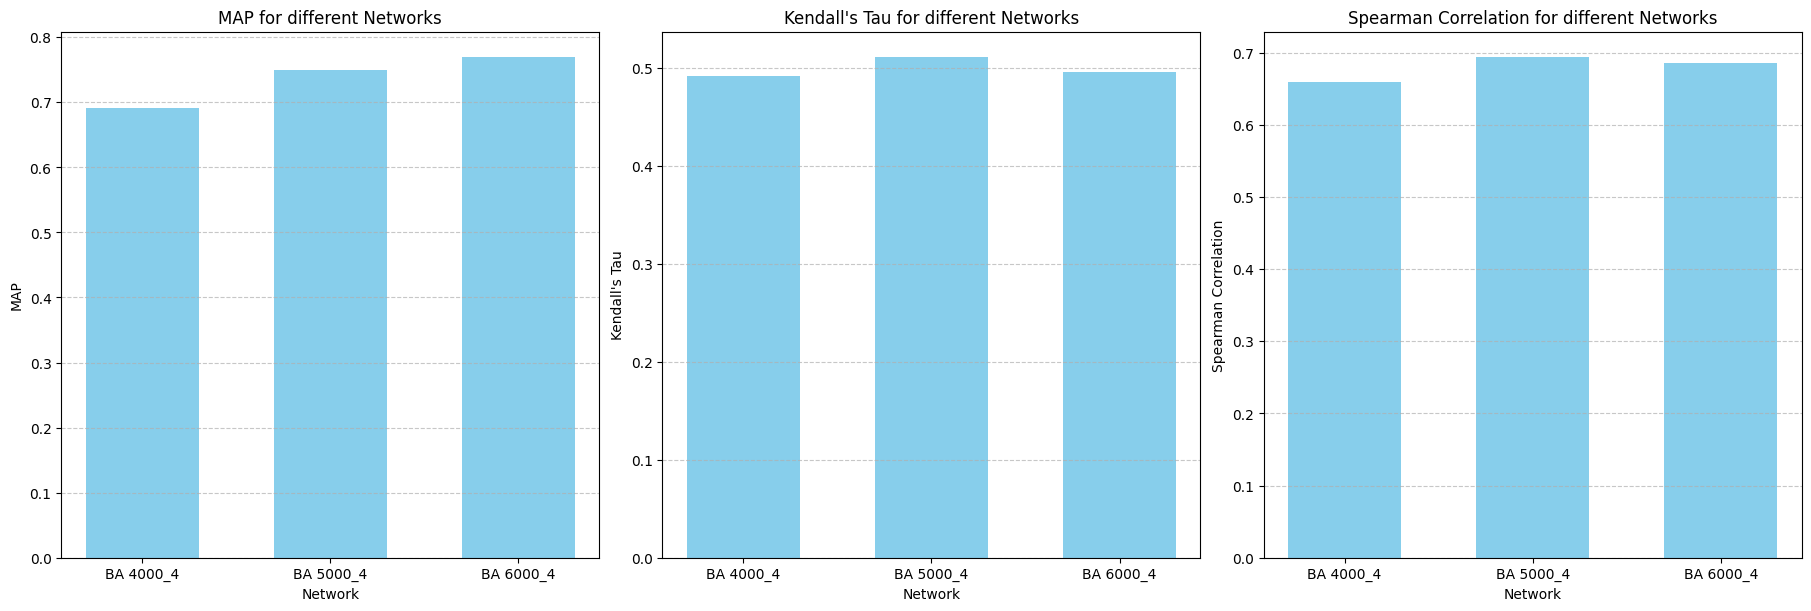

In [43]:

# Usage example
folder_path = f'./../data/{save_folder}'  # Replace with the actual folder path
model_files = {
    cl('ba_edgelist_exp1_4000_4_df.csv'): 'ba_edgelist_exp1_4000_4_df.csv',
    cl('ba_edgelist_exp1_5000_4_df.csv'): 'ba_edgelist_exp1_5000_4_df.csv',
    cl('ba_edgelist_exp1_6000_4_df.csv'): 'ba_edgelist_exp1_6000_4_df.csv',
}  # Replace with actual file names

plot_metrics_from_models(folder_path, model_files)



C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'


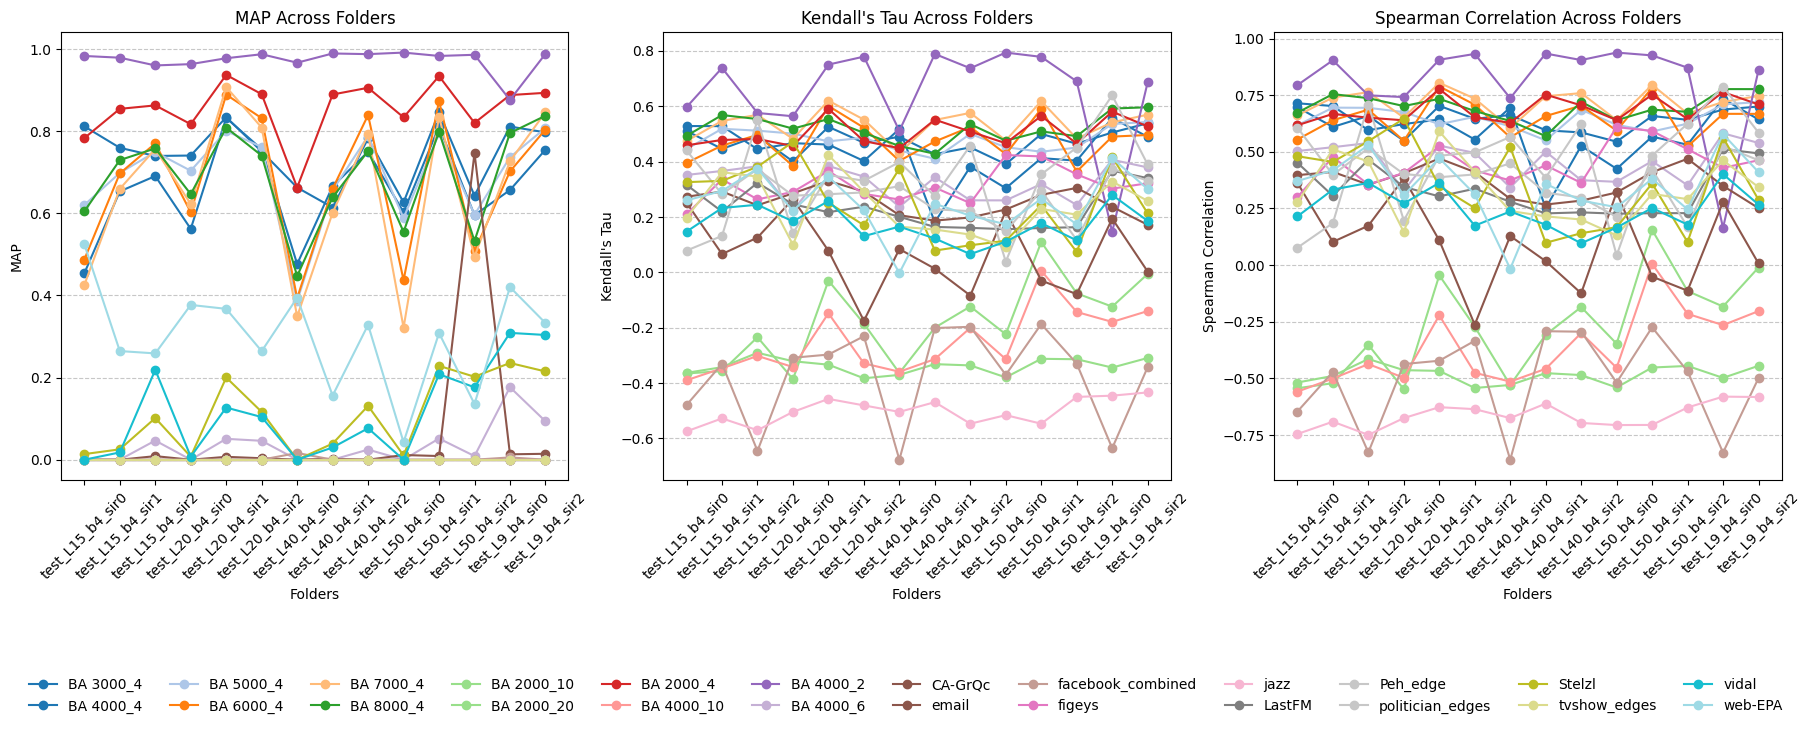

In [44]:

folder_paths = []

for i in range(len(models)):
# for i in range(4):
    # print(f'{i}) {model_params[i]} : {models[i]}')
    _model_L = model_params[i][0]
    sir_alpha = model_params[i][2]
    save_folder = f'./../data/test_L{_model_L}_b4_sir{sir_alpha}'
    folder_paths.append(save_folder)


df = get_df_csv_files(folder_paths[0])


model_files = {cl(item):item for item in df}  # Replace with actual file names

plot_metrics_across_folders(folder_paths, model_files)

C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used w

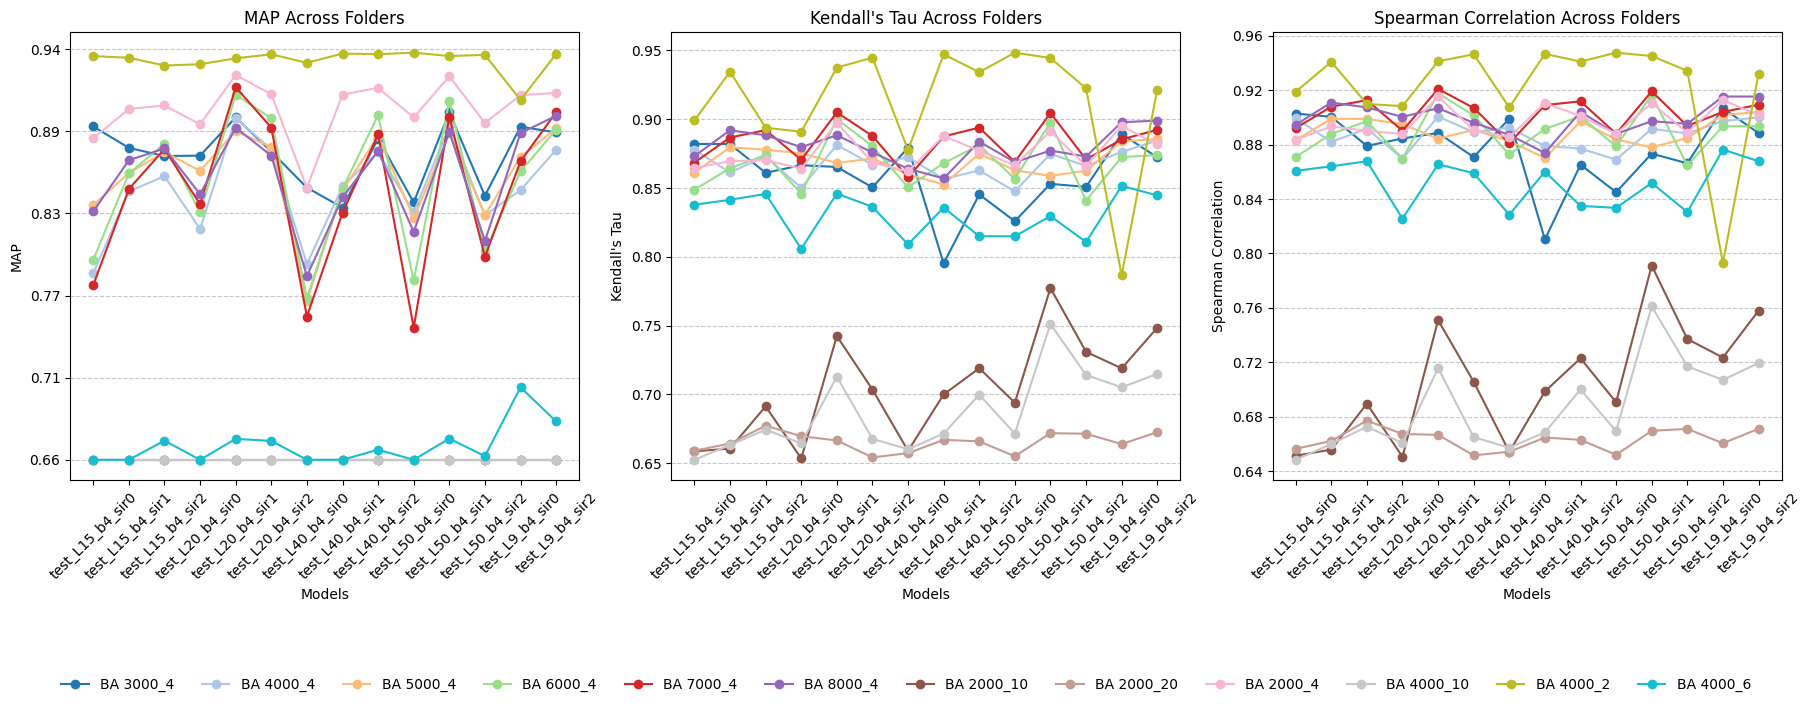

In [45]:
df = get_ba_df_csv_files(folder_paths[0])

# for folder in folder_paths:
#     if 'test_L50_b4_sir2' in folder or 'test_L20_b4_sir2' in folder or 'test_L40_b4_sir2' in folder:
#         folder_paths.remove(folder)

model_files = {cl(item):item for item in df}

plot_metrics_shifted_across_folders(folder_paths, model_files)
print()

C:\Users\venus\AppData\Local\Temp\ipykernel_3596\2397075180.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\2397075180.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\2397075180.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\2397075180.py:66: UserWarning: set_ticklabels() should only be used with 

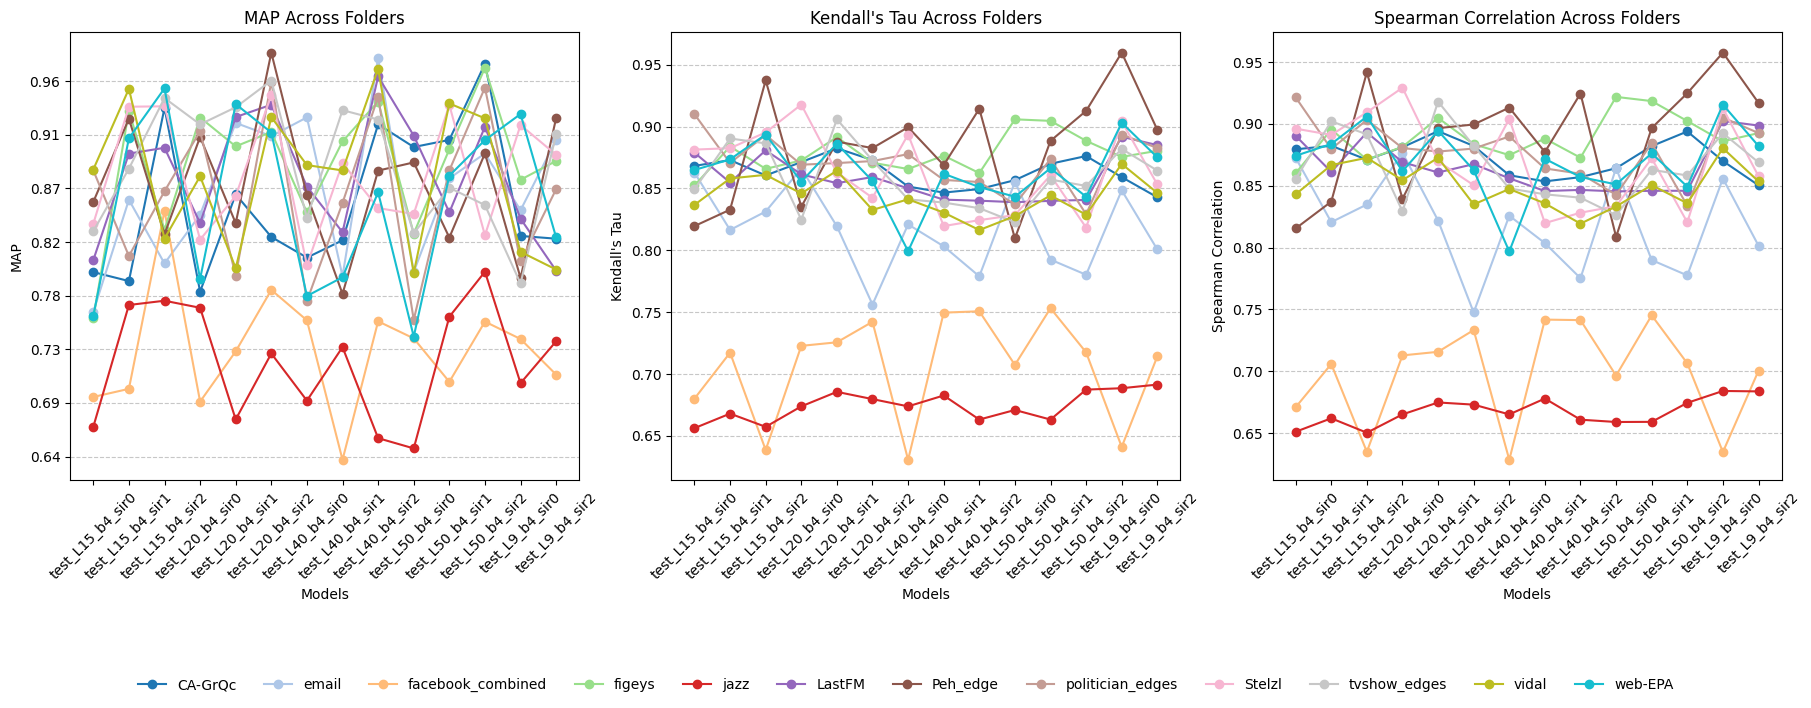

In [52]:
df = get_df_csv_files(folder_paths[0])
df_pr = get_ba_df_csv_files(folder_paths[0])
df = [d for d in df if d not in df_pr]
# for folder in folder_paths:
#     if 'test_L50_b4_sir2' in folder or 'test_L20_b4_sir2' in folder or 'test_L40_b4_sir2' in folder:
#         folder_paths.remove(folder)

model_files = {cl(item):item for item in df}
# plot_metrics_shifted_across_folders(folder_paths, model_files)
plot_metrics_shifted_across_folders_scm(folder_paths, model_files)
print()

In [54]:
# model_files
[fp for fp in folder_paths if fp.endswith('1')]

['./../data/test_L15_b4_sir1',
 './../data/test_L20_b4_sir1',
 './../data/test_L40_b4_sir1',
 './../data/test_L50_b4_sir1',
 './../data/test_L9_b4_sir1']

C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:199: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:215: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])


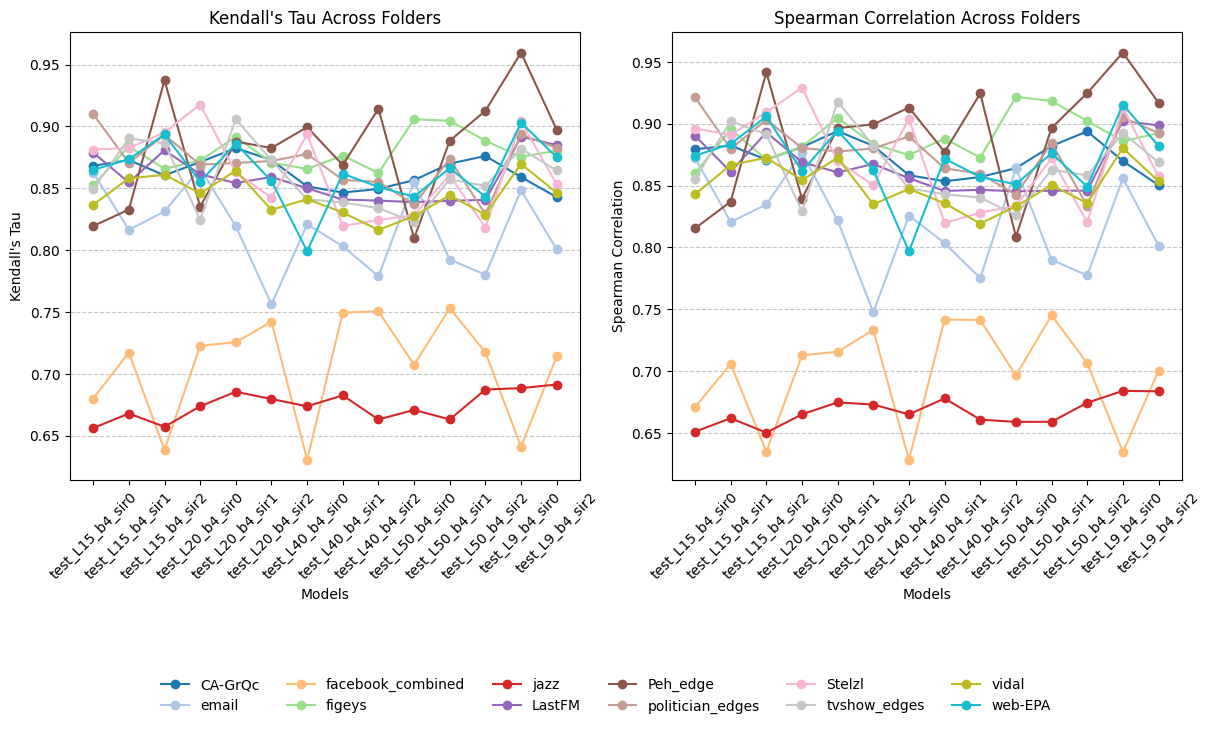

In [22]:
df = get_df_csv_files(folder_paths[0])
df_pr = get_ba_df_csv_files(folder_paths[0])
df = [d for d in df if d not in df_pr]
# for folder in folder_paths:
#     if 'test_L50_b4_sir2' in folder or 'test_L20_b4_sir2' in folder or 'test_L40_b4_sir2' in folder:
#         folder_paths.remove(folder)

model_files = {cl(item):item for item in df}

plot_metrics_shifted_across_folders_no_map(folder_paths, model_files)
print()

C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('tab20')  # Use a colormap like 'tab20' or 'tab20c'
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.2f}" for tick in adjusted_ticks])
C:\Users\venus\AppData\Local\Temp\ipykernel_3596\1910867755.py:163: UserWarning: set_ticklabels() should only be used w

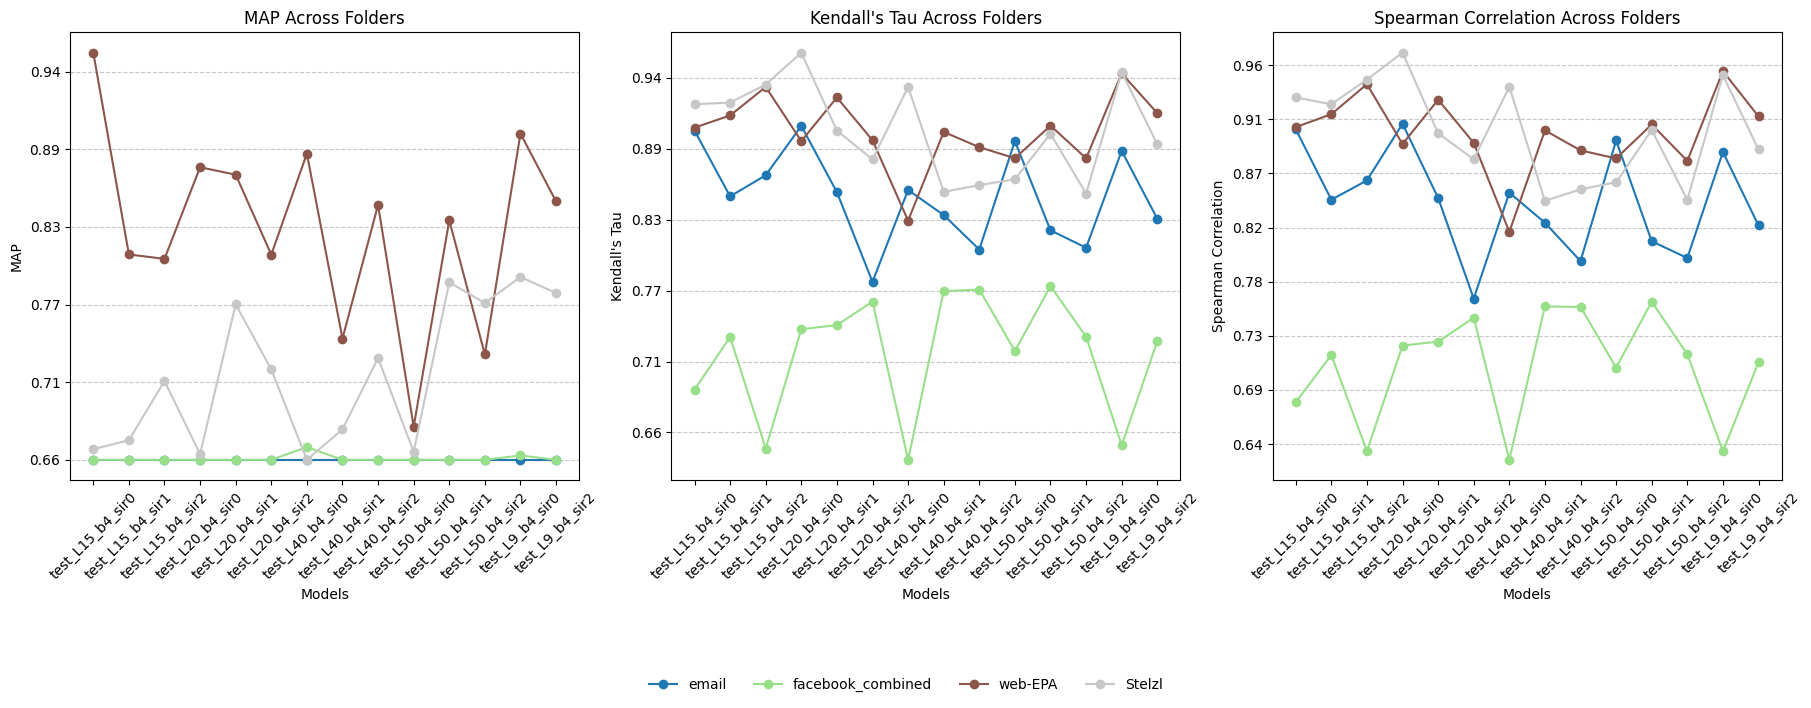

In [23]:


df = get_df_csv_files(folder_paths[0])
df_pr = get_ba_df_csv_files(folder_paths[0])
df = [d for d in df if d not in df_pr]
# for folder in folder_paths:
#     if 'test_L50_b4_sir2' in folder or 'test_L20_b4_sir2' in folder or 'test_L40_b4_sir2' in folder:
#         folder_paths.remove(folder)


df =  ['email_df.csv', 'facebook_combined_df.csv', 'web-EPA_df.csv', 'Stelzl_df.csv']
model_files = {cl(item):item for item in df}


spec_model_files = ['email_df.csv', 'facebook_combined_df.csv']

m, metrics = plot_metrics_shifted_across_folders(folder_paths, model_files)

# Save execution times to JSON after each graph is processed
with open('test.json', "w") as json_file:
    json.dump(metrics, json_file, indent=4)


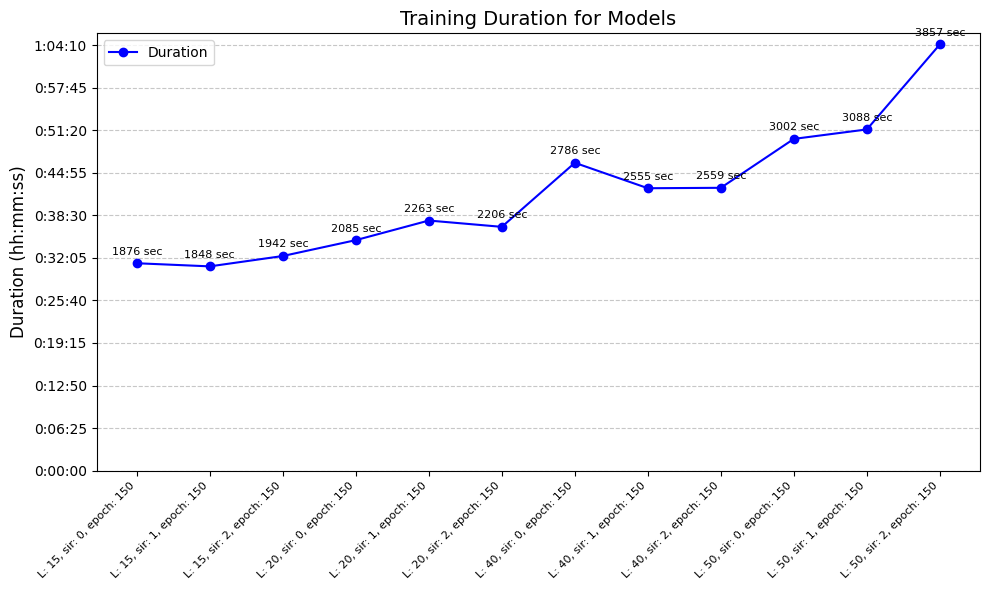

In [24]:

# Load JSON data
with open('./../data/learning_durations.json') as f:
    data = json.load(f)

# Process the data
x_labels = []
y_values = []
formatted_durations = []

for entry in data:
    label = f"L: {entry['L']}, sir: {entry['sir_alpha']}, epoch: {entry['num_epoch']}"
    seconds = entry['duration_seconds']
    duration = str(timedelta(seconds=seconds))
    
    x_labels.append(label)
    y_values.append(seconds)  # Store the raw seconds for plotting
    formatted_durations.append(duration)  # Store formatted durations for y-axis

# Convert y-values to formatted durations
y_ticks = [str(timedelta(seconds=val)) for val in range(0, int(max(y_values)) + 1, int(max(y_values)//10))]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot
ax.plot(range(len(x_labels)), y_values, marker='o', linestyle='-', color='blue', label='Duration')

# Set custom y-axis labels (formatted durations)
ax.set_yticks(range(0, int(max(y_values)) + 1, int(max(y_values)//10)))
ax.set_yticklabels(y_ticks)

# Customize x-axis labels
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)

# Set axis labels and title
ax.set_ylabel("Duration (hh:mm:ss)", fontsize=12)
ax.set_title("Training Duration for Models", fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate points with seconds
for i, (x, y) in enumerate(zip(range(len(x_labels)), y_values)):
    ax.text(x, y + max(y_values) * 0.02, f"{int(y)} sec", ha='center', fontsize=8)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

In [25]:

# Load JSON data
with open('./../data/learning_durations.json') as f:
    data = json.load(f)

# Calculate the average duration in seconds
total_seconds = sum(entry['duration_seconds'] for entry in data)
average_seconds = total_seconds / len(data)

# Convert to hh:mm:ss format
average_duration_formatted = str(timedelta(seconds=int(average_seconds)))

# Print the results
print(f"Average Duration in Seconds: {average_seconds:.2f} seconds")
print(f"Average Duration in hh:mm:ss: {average_duration_formatted}")

Average Duration in Seconds: 2506.11 seconds
Average Duration in hh:mm:ss: 0:41:46


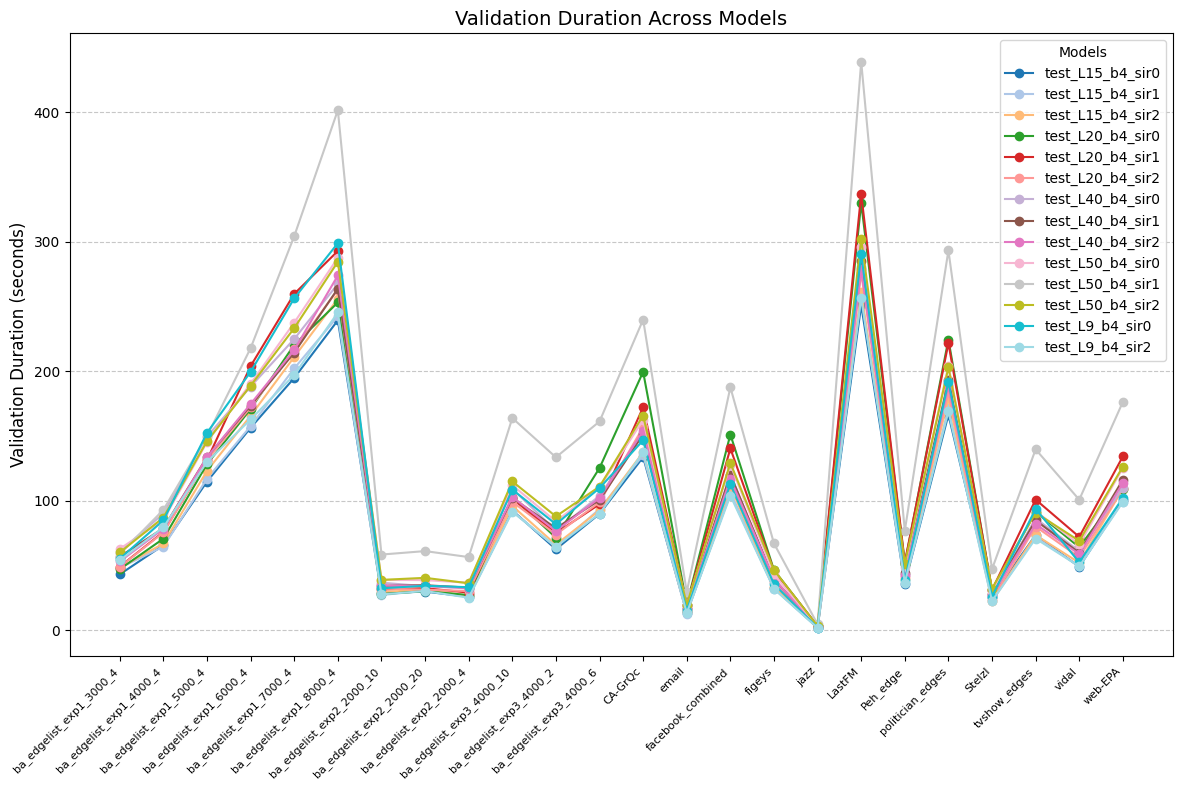

In [26]:

# Example usage
path = "./../data"  # Replace with your desired path
models = list_folders_in_path(path)
model_params = [extract_numbers_from_string(g) for g in models] 


# List of JSON files for each model
model_files = {models[i]: f'./../data/{models[i]}/validation_results_sir{model_params[i][2]}_L{model_params[i][0]}_ep150.json' for i in range(len(models))}

model_files['test_L9_b4_sir0']= './../data/test_L9_b4_sir0/validation_results.json'
del model_files['test_L9_b4_sir1']
model_files['test_L9_b4_sir2']= './../data/test_L9_b4_sir2/validation_results_sir2_L9_ep200.json'
import matplotlib.pyplot as plt
import json
import matplotlib.cm as cm
import numpy as np

# Initialize data storage
model_durations = {}  # {Model Name: (x_labels, y_values)}

# Define your model_files here
# model_files = ...

# Process data for each model
for model_name, file_path in model_files.items():
    with open(file_path) as f:
        data = json.load(f)

    x_labels = []
    y_values = []

    for entry in data:
        label = entry["graph_name"]
        duration = entry["duration"]
        x_labels.append(label)
        y_values.append(duration)

    model_durations[model_name] = (x_labels, y_values)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a colormap with distinct colors
colors = cm.tab20(np.linspace(0, 1, len(model_durations)))

# Plot each model's validation durations
for idx, (model_name, (x_labels, y_values)) in enumerate(model_durations.items()):
    indices = range(len(x_labels))
    ax.plot(indices, y_values, marker='o', linestyle='-', label=model_name, color=colors[idx])

# Customize the plot
all_x_labels = next(iter(model_durations.values()))[0]
ax.set_xticks(range(len(all_x_labels)))
ax.set_xticklabels(all_x_labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel("Validation Duration (seconds)", fontsize=12)
ax.set_title("Validation Duration Across Models", fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Models", fontsize=10, loc="best")

plt.tight_layout()
plt.show()


In [27]:
import platform
import os
import psutil

# Get OS information
os_info = {
    "System": platform.system(),
    "Node Name": platform.node(),
    "Release": platform.release(),
    "Version": platform.version(),
    "Machine": platform.machine(),
    "Processor": platform.processor(),
}

# Get CPU information
cpu_info = {
    "Physical Cores": psutil.cpu_count(logical=False),
    "Total Cores": psutil.cpu_count(logical=True),
    "Max Frequency (MHz)": psutil.cpu_freq().max,
    "Min Frequency (MHz)": psutil.cpu_freq().min,
    "Current Frequency (MHz)": psutil.cpu_freq().current,
    "CPU Usage (%)": psutil.cpu_percent(interval=1),
}

# Print OS information
print("Operating System Information:")
for key, value in os_info.items():
    print(f"{key}: {value}")

print("\nCPU Information:")
# Print CPU information
for key, value in cpu_info.items():
    print(f"{key}: {value}")


Operating System Information:
System: Windows
Node Name: Eva
Release: 10
Version: 10.0.19045
Machine: AMD64
Processor: Intel64 Family 6 Model 142 Stepping 11, GenuineIntel

CPU Information:
Physical Cores: 4
Total Cores: 8
Max Frequency (MHz): 1992.0
Min Frequency (MHz): 0.0
Current Frequency (MHz): 1792.0
CPU Usage (%): 45.2
